In [228]:
import pandas as pd
import numpy as np
import pylab
import math

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

# Set default matplot figure size
pylab.rcParams['figure.figsize'] = (10.0, 8.0) 

In [229]:
#Tree packages for checking the feature importance
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier() 

In [230]:
credit = pd.read_csv("C:\\Users\\Jeroen\\Desktop\\Ubiqum\\Data Science\\Excel Files\\Credit_1.csv", header = 0)
credit = credit[credit.columns[2:len(credit.columns)]]

In [231]:
#Remove the values that had no debt in september but were given a default status in october
credit = credit[-((credit.CUR_BIL_SEP == 0) & (credit.DEFAULT == 'Defaults'))]

In [232]:
credit.head()

,CREDIT,SEX,EDUCATION,MARRIAGE,AGE,PAYSTAT_APR,PAYSTAT_MAY,PAYSTAT_JUNE,PAYSTAT_JULY,PAYSTAT_AUG,...,CUR_BIL_JULY,CUR_BIL_AUG,CUR_BIL_SEP,PAID_APR,PAID_MAY,PAID_JUNE,PAID_JULY,PAID_AUG,PAID_SEP,DEFAULT
0,20000,Female,University,Single,24,-2,-2,-1,-1,2,...,689,3102,3913,0,0,0,0,689,0,Defaults
1,120000,Female,University,Married,26,2,0,0,0,2,...,2682,1725,2682,2000,0,1000,1000,1000,0,Defaults
2,90000,Female,University,Married,34,0,0,0,0,0,...,13559,14027,29239,5000,1000,1000,1000,1500,1518,Pays
3,50000,Female,University,Single,37,0,0,0,0,0,...,49291,48233,46990,1000,1069,1100,1200,2019,2000,Pays
4,50000,Male,University,Single,57,0,0,0,-1,0,...,35835,5670,8617,679,689,9000,10000,36681,2000,Pays


In [233]:
#Make a variable that states whether the person has defaulted in the past
credit['DEFAULTED_BEFORE'] = (np.where((credit['PAYSTAT_APR'] >= 1) |
                                       (credit['PAYSTAT_MAY'] >= 1) |
                                       (credit['PAYSTAT_JUNE'] >= 1) |
                                       (credit['PAYSTAT_JULY'] >= 1) |
                                       (credit['PAYSTAT_AUG'] >= 1) |
                                       (credit['PAYSTAT_SEP'] >= 1)
                                       , "Yes" , "No"))

print("Of the people that will default in October,",
      (len(credit[((credit.DEFAULT == "Defaults") & (credit.DEFAULTED_BEFORE == "Yes"))]) / 
      len(credit[credit.DEFAULT == "Defaults"]))*100,
      "percent has defaulted at least once in the previous months as well.")

Of the people that will default in October, 64.19206817436906 percent has defaulted at least once in the previous months as well.


In [234]:
#Create variable that provides ratio of current bill and amount that can be borrowed
credit['CREDIT_RATIO'] = (credit['CUR_BIL_AUG'] / credit['CREDIT'])

#Check for the difference in the ratio people that default and people that pay
defaulters = credit[credit.DEFAULT == "Defaults"]
nondefaulters = credit[credit.DEFAULT == "Pays"]

print("Average credit ratio is", credit.CREDIT_RATIO.mean())
print("Average credit ratio for defaulters is", defaulters.CREDIT_RATIO.mean())
print("Average credit ratio for non-defaulters is", nondefaulters.CREDIT_RATIO.mean())

Average credit ratio is 0.4184021863875477
Average credit ratio for defaulters is 0.5280123430552899
Average credit ratio for non-defaulters is 0.3897751886137699


(array([1.0000e+00, 1.0000e+00, 2.0000e+00, 1.0472e+04, 4.6740e+03,
        4.8590e+03, 3.2210e+03, 6.7000e+01, 4.6000e+01, 1.1000e+01,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-1.39554 , -1.006738, -0.617936, -0.229134,  0.159668,  0.54847 ,
         0.937272,  1.326074,  1.714876,  2.103678,  2.49248 ,  2.881282,
         3.270084,  3.658886,  4.047688,  4.43649 ,  4.825292,  5.214094,
         5.602896,  5.991698,  6.3805  ]),
 <a list of 20 Patch objects>)

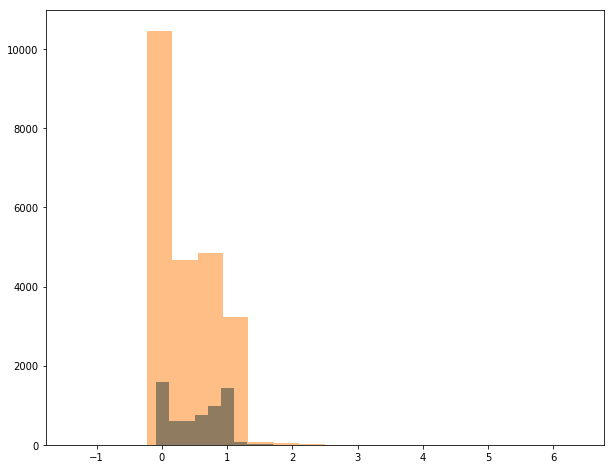

In [235]:
plt.hist(defaulters.CREDIT_RATIO, bins = 20)
plt.hist(nondefaulters.CREDIT_RATIO, bins = 20, alpha = 0.5)

In [236]:
#convert all categories into numerical variables so they can be proberly used to model with
credit.SEX = pd.CategoricalIndex(credit.SEX)
credit.EDUCATION = pd.CategoricalIndex(credit.EDUCATION)
credit.MARRIAGE = pd.CategoricalIndex(credit.MARRIAGE)
credit.DEFAULT = pd.CategoricalIndex(credit.DEFAULT)
credit.DEFAULTED_BEFORE = pd.CategoricalIndex(credit.DEFAULTED_BEFORE)

credit['SEX'] = credit.SEX.cat.codes
credit['EDUCATION'] = credit.EDUCATION.cat.codes
credit['MARRIAGE'] = credit.MARRIAGE.cat.codes
credit['DEFAULT'] = credit.DEFAULT.cat.codes
credit['DEFAULTED_BEFORE'] = credit.DEFAULTED_BEFORE.cat.codes

In [237]:
credit.head()

,CREDIT,SEX,EDUCATION,MARRIAGE,AGE,PAYSTAT_APR,PAYSTAT_MAY,PAYSTAT_JUNE,PAYSTAT_JULY,PAYSTAT_AUG,...,CUR_BIL_SEP,PAID_APR,PAID_MAY,PAID_JUNE,PAID_JULY,PAID_AUG,PAID_SEP,DEFAULT,DEFAULTED_BEFORE,CREDIT_RATIO
0,20000,0,3,2,24,-2,-2,-1,-1,2,...,3913,0,0,0,0,689,0,0,1,0.155100
1,120000,0,3,0,26,2,0,0,0,2,...,2682,2000,0,1000,1000,1000,0,0,1,0.014375
2,90000,0,3,0,34,0,0,0,0,0,...,29239,5000,1000,1000,1000,1500,1518,1,0,0.155856
3,50000,0,3,2,37,0,0,0,0,0,...,46990,1000,1069,1100,1200,2019,2000,1,0,0.964660
4,50000,1,3,2,57,0,0,0,-1,0,...,8617,679,689,9000,10000,36681,2000,1,0,0.113400


In [238]:
#Keep only the variables that seem important and are not overly correlated with each other
credit = credit[["PAYSTAT_SEP", "CUR_BIL_SEP", "PAID_SEP", "CREDIT", "CREDIT_RATIO", "AGE", "DEFAULT"]]

In [239]:
#Split the data in a train and testset
credit_dep = credit.DEFAULT
credit_indep = credit.drop(['DEFAULT'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(credit_indep, credit_dep, test_size=0.3)

In [240]:
len(credit_indep)
len(credit_dep)


29466

In [241]:
# Build a forest and compute the feature importances
## Fit the model on your training data.
rf.fit(X_train, y_train) 
## And score it on your testing data.
rf.score(X_test, y_test)


D:\Users\Jeroen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8096153846153846

In [242]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
print(feature_importances)

              importance
CREDIT_RATIO    0.216412
CUR_BIL_SEP     0.215901
PAYSTAT_SEP     0.174113
PAID_SEP        0.155147
AGE             0.139598
CREDIT          0.098829


In [243]:
#standardize the data
from sklearn import preprocessing

# Get column names
names = credit_indep.columns

#scale the data
scaled_credit = pd.DataFrame(preprocessing.scale(credit_indep))

#return columnnames
scaled_credit.columns = names

D:\Users\Jeroen\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


In [244]:
#Restore row index to make combining the dataframes easier
credit_dep.index = range(len(credit_dep))


In [245]:
#add the dataframes together
credit = scaled_credit
credit["DEFAULT"] = credit_dep

In [246]:
#See whether there are Na's due the scaling the dataframes
print(credit_indep.isnull().values.any())
print(credit_dep.isnull().values.any())

print(scaled_credit.isnull().values.any())
print(credit.isnull().values.any())

False
False
False
False


In [247]:
# Save the dataframe and create a new 
credit.to_csv("C:\\Users\\Jeroen\\Desktop\\Ubiqum\\Data Science\\Excel Files\\Credit_3.csv")